In [1]:
#Generating Binomial tree data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BS_data import call_binomial_data

#data_frame = first training data set
#data_frame2 = second, shifted training data set
#data_frame_prime = test daat set
data_frame, data_frame2, data_frame_prime = call_binomial_data()

print(data_frame)
# print(data_frame2)
# print(data_frame_prime)

       T     K  price_call_Am  price_call_Eur  price_put_Am  price_put_Eur
0    0.0  30.0      20.000000       20.000000      0.000000       0.000000
1    0.0  34.0      16.000000       16.000000      0.000000       0.000000
2    0.0  38.0      12.000000       12.000000      0.000000       0.000000
3    0.0  42.0       8.000000        8.000000      0.000000       0.000000
4    0.0  46.0       4.000000        4.000000      0.000000       0.000000
..   ...   ...            ...             ...           ...            ...
116  0.4  54.0       1.560551        1.560551      4.884804       4.703426
117  0.4  58.0       0.678619        0.678619      8.148531       7.758003
118  0.4  62.0       0.261865        0.261865     12.000000      11.277759
119  0.4  66.0       0.088967        0.088967     16.000000      15.041370
120  0.4  70.0       0.028091        0.028091     20.000000      18.917003

[121 rows x 6 columns]


In [2]:
import math
import torch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
#First data set
train_x = np.array(list(zip(data_frame['K'], data_frame['T'])), dtype = np.float32)
train_x = torch.from_numpy(train_x)

train_y = np.array(data_frame['price_put_Eur'], dtype = np.float32)
train_y = torch.from_numpy(train_y)

#Second, shifted data set
train_x2 = np.array(list(zip(data_frame2['K'], data_frame2['T'])), dtype = np.float32)
train_x2 = torch.from_numpy(train_x2)

train_y2 = np.array(data_frame2['price_put_Am'], dtype = np.float32)
train_y2 = torch.from_numpy(train_y2)

#Test data set
test_x = np.array(list(zip(data_frame_prime['K'], data_frame_prime['T'])), dtype = np.float32)
test_x = torch.from_numpy(test_x)

test_y = np.array(list(zip(data_frame_prime['price_put_Eur'], data_frame_prime['price_put_Am'])), dtype = np.float32)
test_y = torch.from_numpy(test_y)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([121, 2])
torch.Size([121])
torch.Size([81, 2])
torch.Size([81, 2])


In [8]:
#Define a multitask GP model with an index kernel
#This model can take different training inputs for each output task

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel(ard_num_dims=2) #kernel of the standard GP

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1) #index kernel of the multitask GP

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)


likelihood = gpytorch.likelihoods.GaussianLikelihood()

#training index data
train_i_task1 = torch.full_like(train_x, dtype=torch.long, fill_value=0)
train_i_task2 = torch.full_like(train_x2, dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x, train_x2]) #training inputs
full_train_i = torch.cat([train_i_task1, train_i_task2]) #training indices associated to the desired tasks
full_train_y = torch.cat([train_y, train_y2]) #training observations

# Here we have two items that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [9]:
#Training the model
#NOTE: due to an error in the GPyTorch code, this cell may raise an exception regarding the Cholesky decomposition
#If this error is raised, try re-running the previous cell and then this cell with fewer training iterations 
#or a lower learning rate lr
training_iterations =  101

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y)
    loss.backward()
    if(i%10 == 0):
        print('Iter %d/101 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 2.093
Iter 11/50 - Loss: 0.926
Iter 21/50 - Loss: 0.412
Iter 31/50 - Loss: -0.027
Iter 41/50 - Loss: -0.413
Iter 51/50 - Loss: -0.678
Iter 61/50 - Loss: -0.767
Iter 71/50 - Loss: -0.824
Iter 81/50 - Loss: -0.962
Iter 91/50 - Loss: -1.001
Iter 101/50 - Loss: -1.043


In [10]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

mse [Eur, Am]:  [0.0016527827, 0.0013975374]


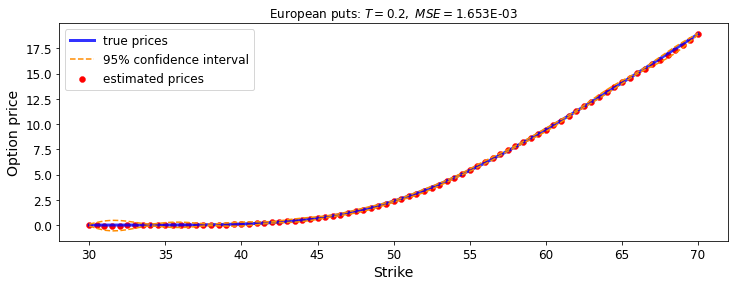

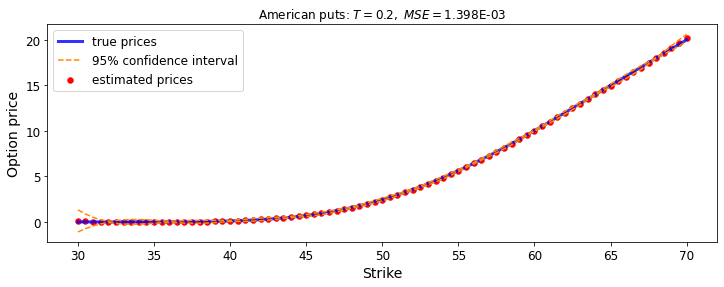

In [11]:
#Plotting the test data estimates

# Set into eval mode
model.eval()
likelihood.eval()

#test index data
test_i_task1 = torch.full_like(test_x, dtype=torch.long, fill_value=0)
test_i_task2 = torch.full_like(test_x, dtype=torch.long, fill_value=1)

#price estimates
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y1 = likelihood(model(test_x, test_i_task1))
    observed_pred_y2 = likelihood(model(test_x, test_i_task2))

mean = np.transpose([observed_pred_y1.mean.numpy(), observed_pred_y2.mean.numpy()])
lower1, upper1 = observed_pred_y1.confidence_region()
lower2, upper2 = observed_pred_y2.confidence_region()
lower = np.transpose([lower1.numpy(), lower2.numpy()])
upper = np.transpose([upper1.numpy(), upper2.numpy()])

from sklearn.metrics import mean_squared_error
mse = [mean_squared_error(mean[:,0], test_y[:,0].numpy()), mean_squared_error(mean[:,1], test_y[:,1].numpy())]
print('mse [Eur, Am]: ', mse)

# Initialize plots
f, (y1_ax) = plt.subplots(1, 1, figsize=(12, 4))
#European puts
y1_ax.scatter(test_x[:,0].numpy(), mean[:, 0], c='r', alpha=1, linewidth = 0.4, label='estimated prices')
y1_ax.plot(test_x[:,0].numpy(), test_y[:, 0].numpy(), alpha = 0.8, color = 'b', linewidth = 3.0, label='true prices')
y1_ax.plot(test_x[:,0].numpy(), lower[:, 0], c='darkorange', alpha=1, linestyle='dashed', label='95% confidence interval')
y1_ax.plot(test_x[:,0].numpy(), upper[:, 0], c='darkorange', alpha=1, linestyle='dashed')
y1_ax.set_xlabel('Strike')
y1_ax.set_ylabel('Option price')
y1_ax.legend()
y1_ax.set_title(r'European puts: $T = 0.2, \ MSE = $' + str("{:.3E}".format(mse[0])))

#American puts
f2, (y2_ax) = plt.subplots(1, 1, figsize=(12,4))
y2_ax.scatter(test_x[:,0].numpy(), mean[:, 1], c='r', alpha=1, linewidth = 0.4, label='estimated prices')
y2_ax.plot(test_x[:,0].numpy(), test_y[:, 1].numpy(), alpha = 0.8, color = 'b', linewidth = 3.0, label='true prices')
y2_ax.plot(test_x[:,0].numpy(), lower[:, 1], c='darkorange', alpha=1, linestyle='dashed', label='95% confidence interval')
y2_ax.plot(test_x[:,0].numpy(), upper[:, 1], c='darkorange', alpha=1, linestyle='dashed')
y2_ax.set_xlabel('Strike')
y2_ax.set_ylabel('Option price')
y2_ax.legend()
y2_ax.set_title(r'American puts: $T = 0.2, \ MSE = $' + str("{:.3E}".format(mse[1])))

None